In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split,  GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import os

In [64]:
sp500 = pd.read_csv('../Data/sp500_main.csv')
macro = pd.read_csv('../Data/macro_data.csv')

In [66]:
macro= macro.set_index('Date')
sp500 = sp500.set_index('Date')

In [68]:
macro

,Interest_Rate,GDP,Unemployment,Inflation_x
Date,,,,
2012-10-01,NaN,16420.419,NaN,NaN
2012-12-01,0.16,16420.419,7.9,231.221
2013-01-01,0.14,16648.189,8.0,231.679
2013-02-01,0.15,16648.189,7.7,232.937
2013-03-01,0.14,16648.189,7.5,232.282
...,...,...,...,...
2024-07-01,5.33,29354.321,4.3,313.534
2024-08-01,5.33,29354.321,4.2,314.121
2024-09-01,5.13,29354.321,4.1,314.686


In [70]:
# Loop through each unique ticker (stock) in the DataFrame
indicator = pd.DataFrame()
for ticker in sp500.columns:
    # Calculate SMAs 
    indicator[f'{ticker}_SMA3'] = sp500[ticker].rolling(window=3).mean()
    indicator[f'{ticker}_SMA20'] = sp500[ticker].rolling(window=20).mean()
    indicator[f'{ticker}_SMA50'] = sp500[ticker].rolling(window=50).mean()
    indicator[f'{ticker}_SMA100'] = sp500[ticker].rolling(window=100).mean()
    indicator[f'{ticker}_SMA200'] = sp500[ticker].rolling(window=200).mean()
    
    # Calculate EMA
    indicator[f'{ticker}_EMA3'] = sp500[ticker].ewm(span=3, adjust=False).mean()
    indicator[f'{ticker}_EMA12'] = sp500[ticker].ewm(span=12, adjust=False).mean()
    indicator[f'{ticker}_EMA26'] = sp500[ticker].ewm(span=26, adjust=False).mean()
    
    # Calculate MACD
    indicator[f'{ticker}_MACD'] = indicator[f'{ticker}_EMA12'] - indicator[f'{ticker}_EMA26']
    
    # Calculate Signal line (9-day EMA of the MACD)
    indicator[f'{ticker}_signal'] = indicator[f'{ticker}_MACD'].ewm(span=9, adjust=False).mean()
    
    # Concatenate each ticker's results into the final indicator DataFrame
    indicator = pd.concat([indicator, sp500], axis=1)

In [76]:
indicator.isnull().sum()[indicator.isnull().sum() !=0].max()


199

In [58]:
indicator = indicator.dropna()

In [60]:
indicator

,AAPL_SMA3,AAPL_SMA20,AAPL_SMA50,AAPL_SMA100,AAPL_SMA200,AAPL_EMA3,AAPL_EMA12,AAPL_EMA26,AAPL_MACD,AAPL_signal,...,META,MSFT,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-16,21.622648,22.149670,22.123928,21.399848,19.255896,21.593619,21.973231,22.079777,-0.106546,-0.011439,...,72.411980,36.470516,0.417055,32.160198,61.612793,15.090000,73.066833,47.228729,20.077412,58.180103
2014-10-17,21.542826,22.113195,22.138075,21.419731,19.278008,21.625136,21.924527,22.048434,-0.123908,-0.033932,...,75.722008,37.229950,0.416338,32.425636,62.384460,15.165333,75.454201,47.926689,20.153568,58.571846
2014-10-20,21.706912,22.098783,22.160337,21.440664,19.304330,21.872606,21.954611,22.053741,-0.099130,-0.046972,...,76.719002,37.613934,0.419923,32.365696,63.066200,15.364667,75.762215,48.357098,20.436424,58.931438
2014-10-21,22.165897,22.096898,22.189073,21.468356,19.333196,22.296785,22.072511,22.103165,-0.030654,-0.043708,...,78.453781,38.296593,0.437848,32.836632,63.388348,15.689333,77.824425,49.627388,20.675770,60.138725
2014-10-22,22.559104,22.110646,22.220205,21.498572,19.363245,22.566529,22.190013,22.157469,0.032544,-0.028458,...,78.134750,37.869942,0.427572,32.228710,63.587673,15.406667,76.814735,49.071346,20.678490,59.804775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05,242.899994,231.657998,229.925983,225.818950,206.618661,242.306591,236.702863,232.891135,3.811727,2.213700,...,608.929993,442.619995,145.059998,186.240005,176.029999,369.489990,576.757812,309.079987,95.300003,114.779999
2024-12-06,242.963328,232.438498,230.237383,225.963709,206.914335,242.573294,237.647037,233.628088,4.018949,2.574750,...,623.770020,443.570007,142.440002,191.690002,173.820007,389.220001,547.519958,311.010010,95.699997,113.570000
2024-12-09,244.209997,233.427998,230.621590,226.194462,207.238775,244.661647,239.047493,234.600081,4.447412,2.949282,...,613.570007,446.019989,138.809998,190.449997,170.789993,389.790009,560.619995,308.299988,93.830002,112.900002


In [36]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Merge all the files that have X-variable (features)
features_df = pd.merge(macro, indicator, on='Date', how='outer')
features_df = features_df.fillna(method='ffill').dropna()

In [38]:
# drop the same column names
features_df = features_df.loc[:, ~features_df.columns.duplicated()]

In [40]:
# Make the rows number the same with target and features files
# set the index to the format Datetime
sp500.index = pd.to_datetime(sp500.index)
features_df.index = pd.to_datetime(features_df.index)

# Align the two DataFrames by finding the intersection of their indices
common_index = sp500.index.intersection(features_df.index)

# Reindex both DataFrames to the common index
sp500 = sp500.loc[common_index]
features_df = features_df.loc[common_index]

In [42]:
features_df.shape, sp500.shape

((2556, 224), (2556, 20))

In [44]:
# define X and y
X = features_df 
y = sp500 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


Starting prediction for stock: AAPL
Training set shape for AAPL: X_train: (2195, 1), y_train: (2195,)
Testing set shape for AAPL: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for AAPL: {'alpha': 0.01}
Performance for AAPL - RMSE: 2.68


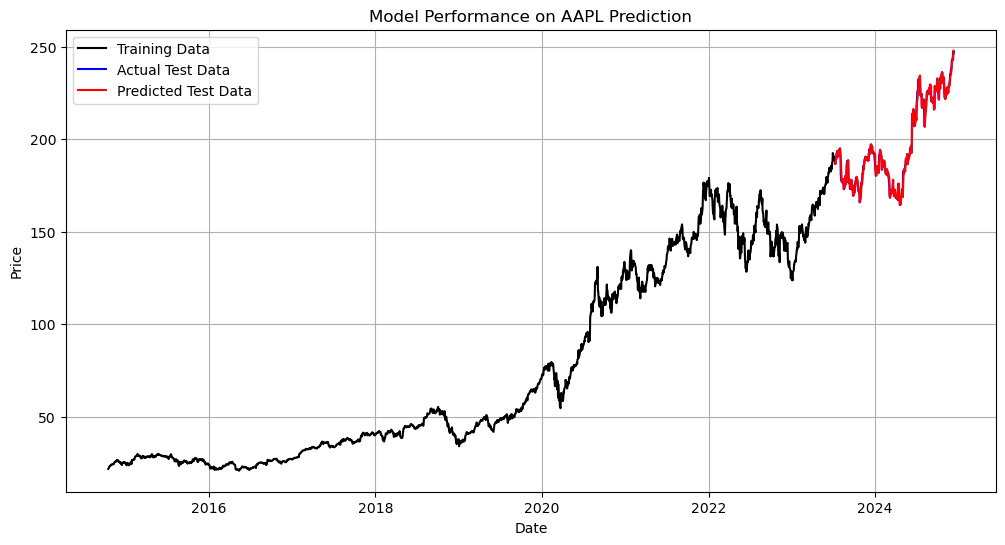


Starting prediction for stock: AMZN
Training set shape for AMZN: X_train: (2195, 1), y_train: (2195,)
Testing set shape for AMZN: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for AMZN: {'alpha': 0.01}
Performance for AMZN - RMSE: 3.03


<Figure size 640x480 with 0 Axes>

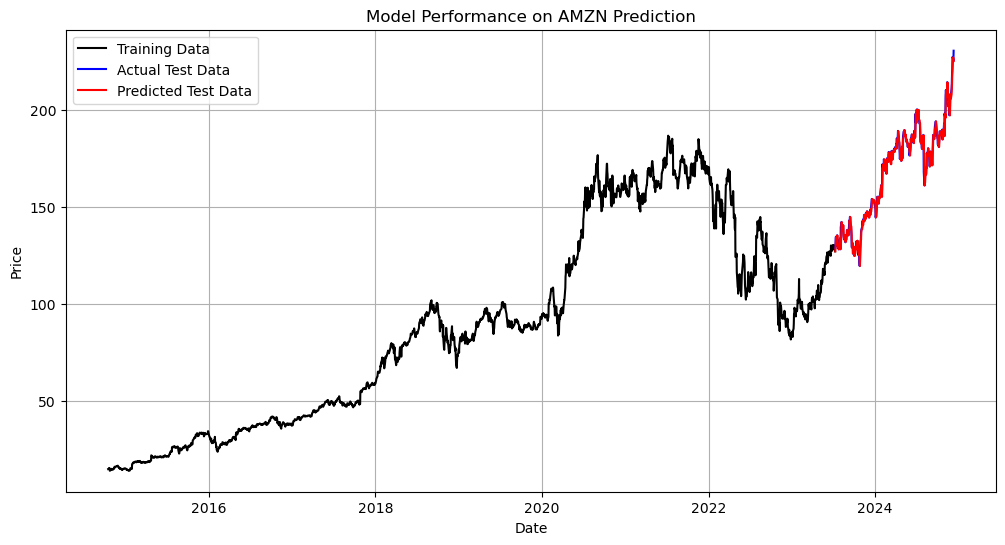


Starting prediction for stock: AVGO
Training set shape for AVGO: X_train: (2195, 1), y_train: (2195,)
Testing set shape for AVGO: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for AVGO: {'alpha': 0.01}
Performance for AVGO - RMSE: 3.74


<Figure size 640x480 with 0 Axes>

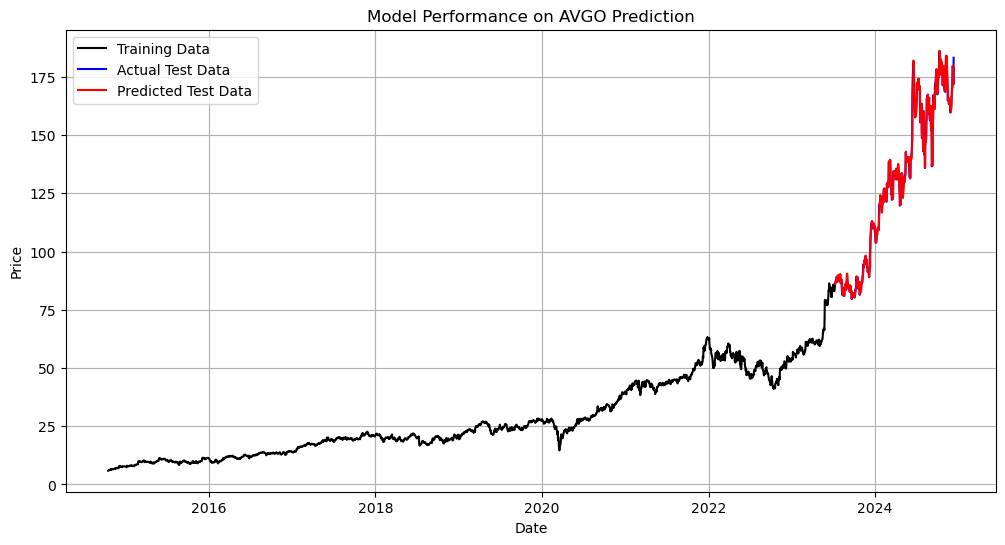


Starting prediction for stock: COST
Training set shape for COST: X_train: (2195, 1), y_train: (2195,)
Testing set shape for COST: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for COST: {'alpha': 0.01}
Performance for COST - RMSE: 8.85


<Figure size 640x480 with 0 Axes>

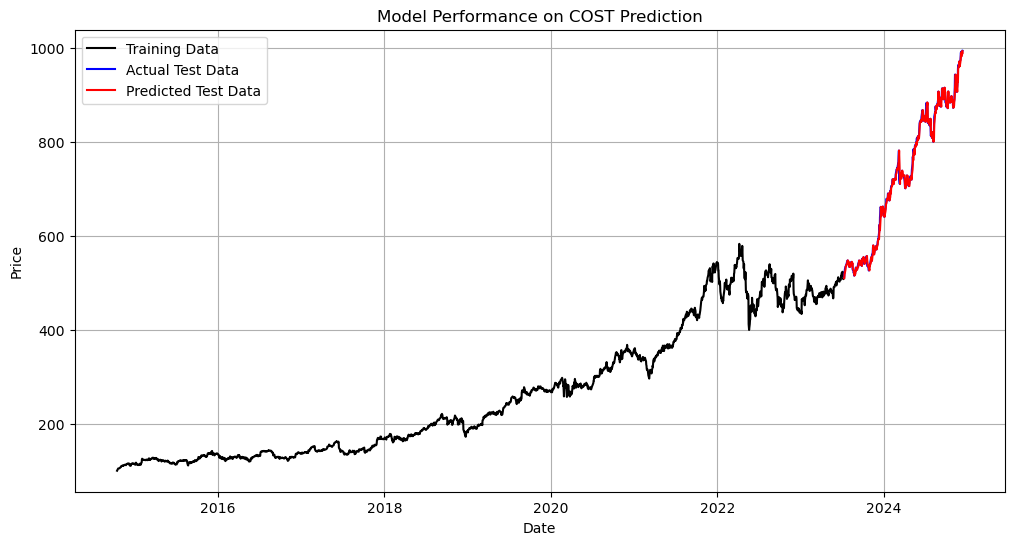


Starting prediction for stock: GOOG
Training set shape for GOOG: X_train: (2195, 1), y_train: (2195,)
Testing set shape for GOOG: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for GOOG: {'alpha': 0.01}
Performance for GOOG - RMSE: 2.69


<Figure size 640x480 with 0 Axes>

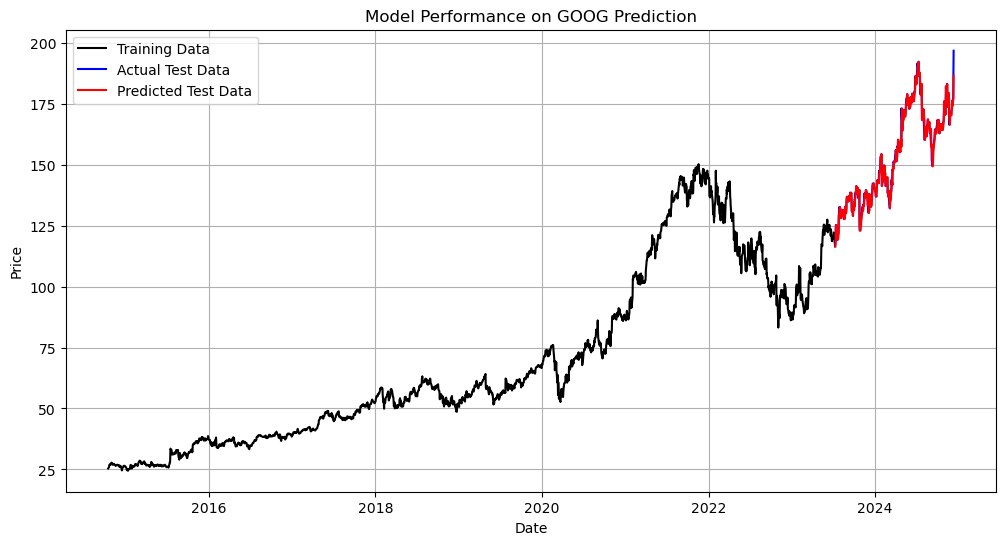


Starting prediction for stock: GOOGL
Training set shape for GOOGL: X_train: (2195, 1), y_train: (2195,)
Testing set shape for GOOGL: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for GOOGL: {'alpha': 0.01}
Performance for GOOGL - RMSE: 2.69


<Figure size 640x480 with 0 Axes>

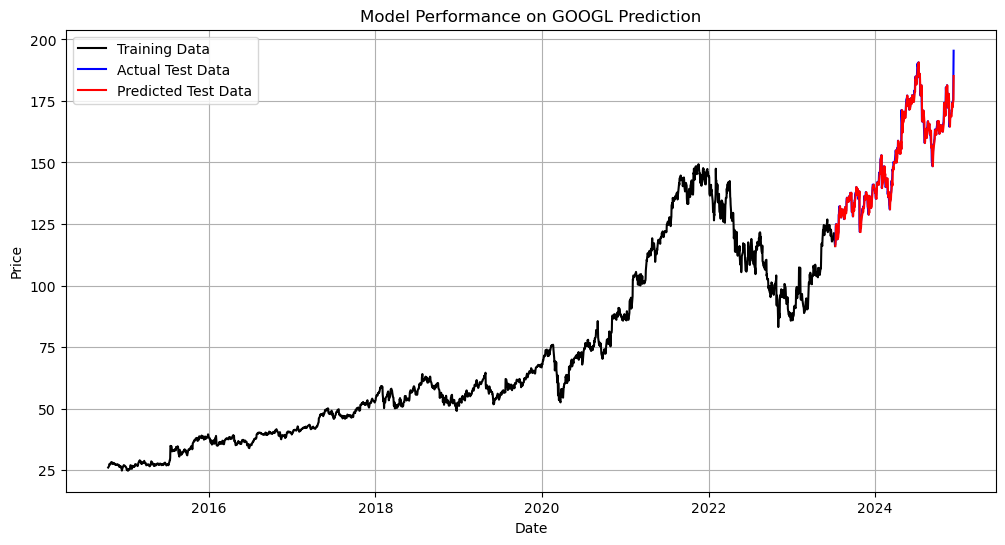


Starting prediction for stock: HD
Training set shape for HD: X_train: (2195, 1), y_train: (2195,)
Testing set shape for HD: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for HD: {'alpha': 0.01}
Performance for HD - RMSE: 4.25


<Figure size 640x480 with 0 Axes>

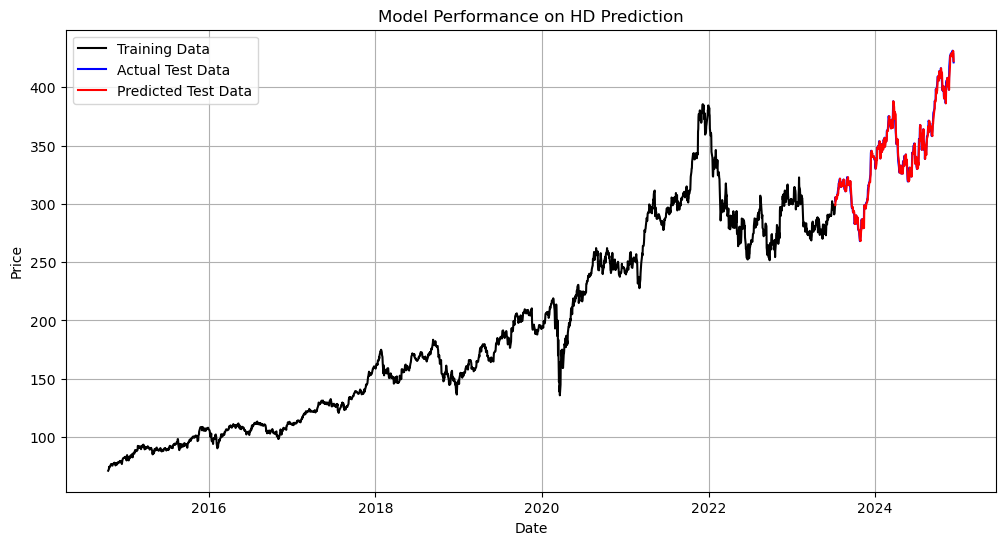


Starting prediction for stock: JPM
Training set shape for JPM: X_train: (2195, 1), y_train: (2195,)
Testing set shape for JPM: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for JPM: {'alpha': 10}
Performance for JPM - RMSE: 2.68


<Figure size 640x480 with 0 Axes>

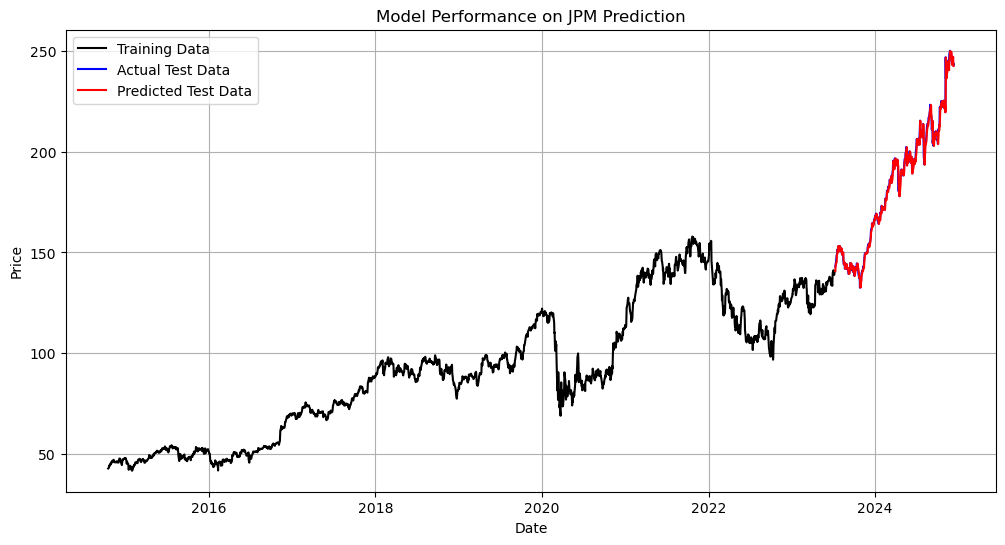


Starting prediction for stock: LLY
Training set shape for LLY: X_train: (2195, 1), y_train: (2195,)
Testing set shape for LLY: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for LLY: {'alpha': 0.01}
Performance for LLY - RMSE: 14.14


<Figure size 640x480 with 0 Axes>

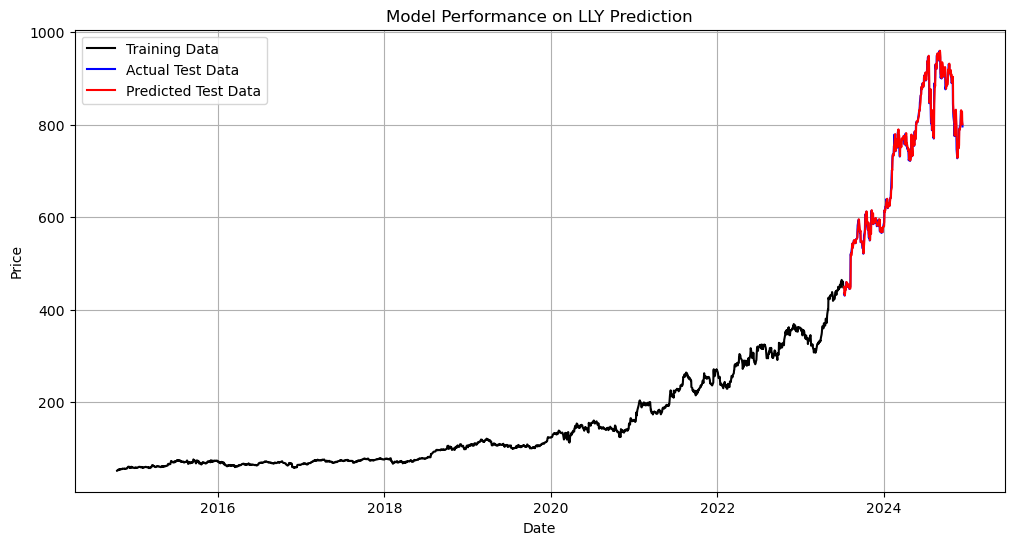


Starting prediction for stock: MA
Training set shape for MA: X_train: (2195, 1), y_train: (2195,)
Testing set shape for MA: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for MA: {'alpha': 0.01}
Performance for MA - RMSE: 4.47


<Figure size 640x480 with 0 Axes>

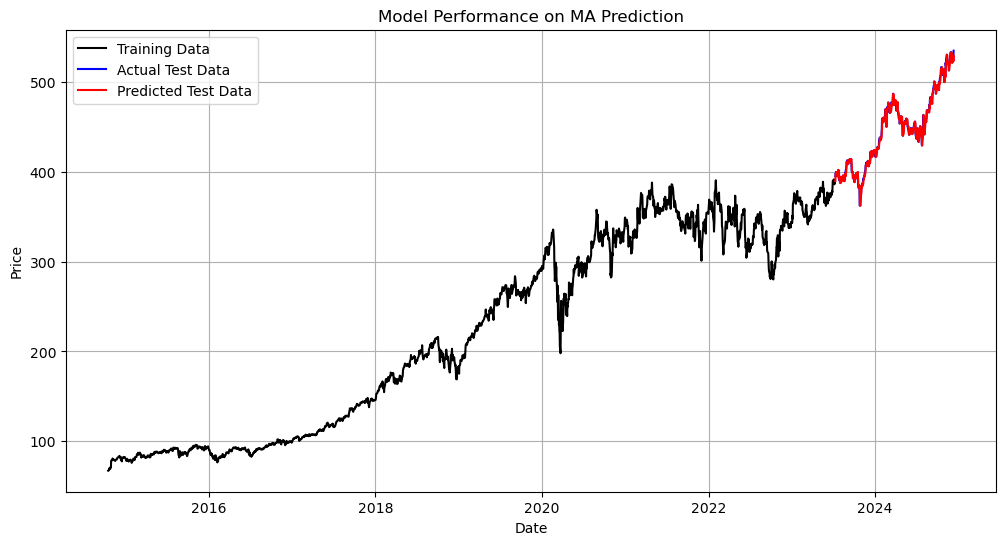


Starting prediction for stock: META
Training set shape for META: X_train: (2195, 1), y_train: (2195,)
Testing set shape for META: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for META: {'alpha': 0.01}
Performance for META - RMSE: 9.58


<Figure size 640x480 with 0 Axes>

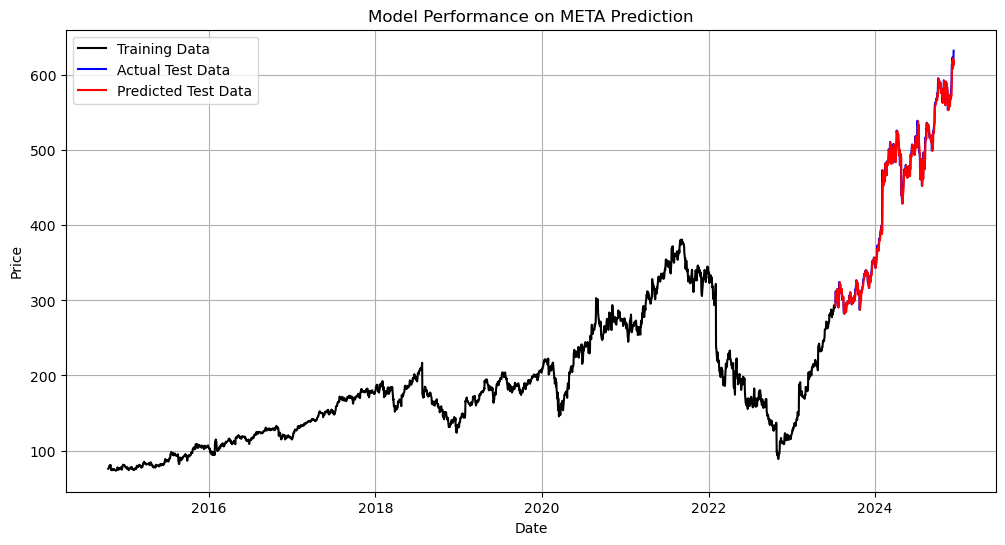


Starting prediction for stock: MSFT
Training set shape for MSFT: X_train: (2195, 1), y_train: (2195,)
Testing set shape for MSFT: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for MSFT: {'alpha': 0.01}
Performance for MSFT - RMSE: 5.01


<Figure size 640x480 with 0 Axes>

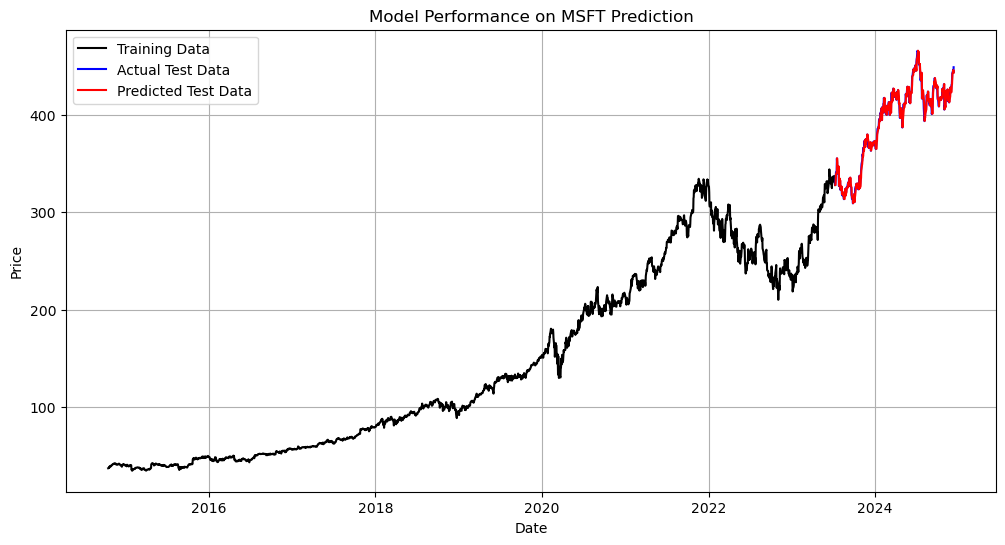


Starting prediction for stock: NVDA
Training set shape for NVDA: X_train: (2195, 1), y_train: (2195,)
Testing set shape for NVDA: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for NVDA: {'alpha': 1}
Performance for NVDA - RMSE: 2.95


<Figure size 640x480 with 0 Axes>

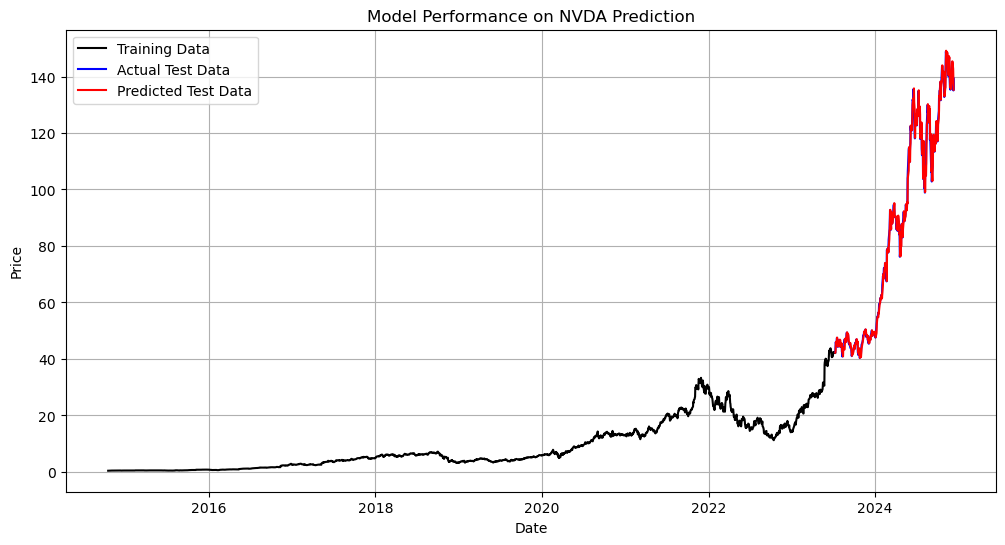


Starting prediction for stock: ORCL
Training set shape for ORCL: X_train: (2195, 1), y_train: (2195,)
Testing set shape for ORCL: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for ORCL: {'alpha': 0.01}
Performance for ORCL - RMSE: 2.78


<Figure size 640x480 with 0 Axes>

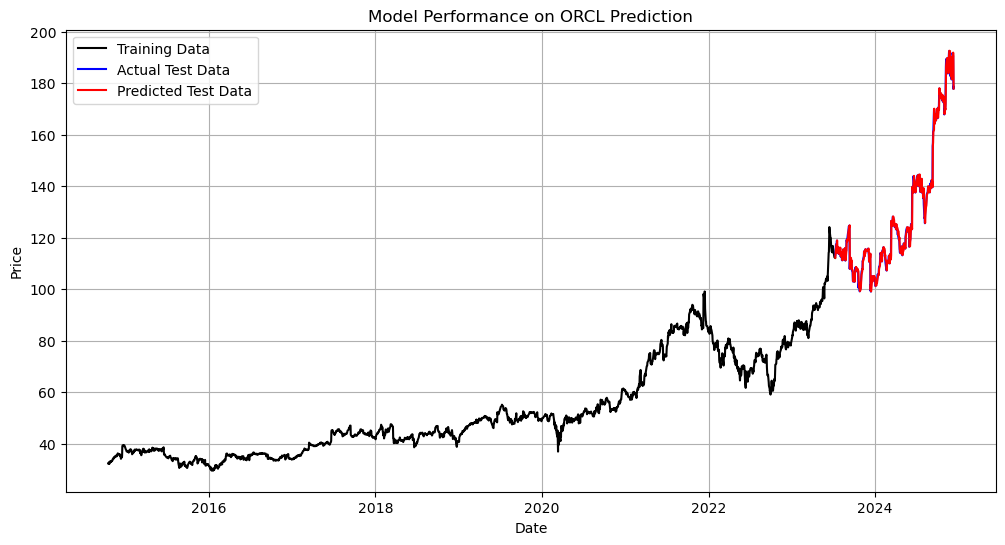


Starting prediction for stock: PG
Training set shape for PG: X_train: (2195, 1), y_train: (2195,)
Testing set shape for PG: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for PG: {'alpha': 0.01}
Performance for PG - RMSE: 1.49


<Figure size 640x480 with 0 Axes>

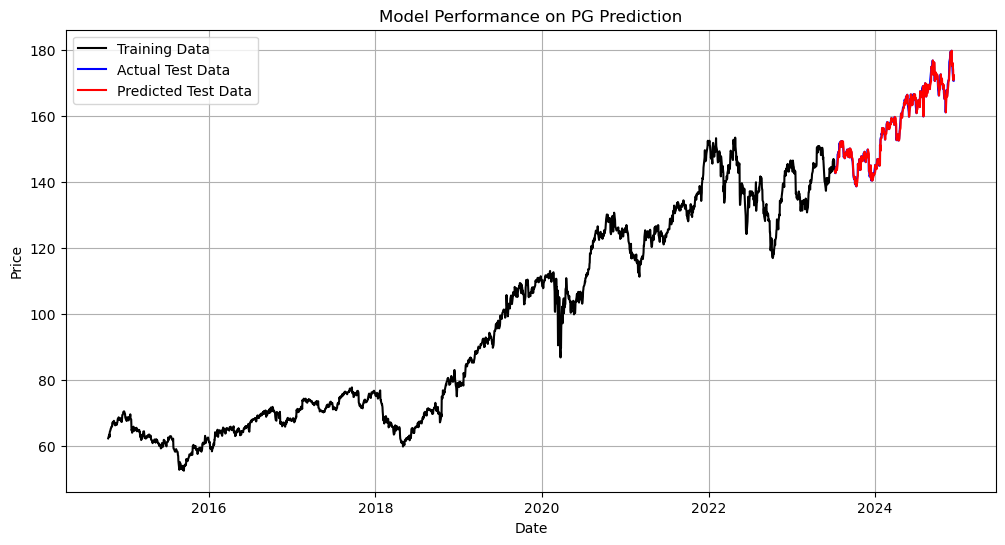


Starting prediction for stock: TSLA
Training set shape for TSLA: X_train: (2195, 1), y_train: (2195,)
Testing set shape for TSLA: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for TSLA: {'alpha': 0.01}
Performance for TSLA - RMSE: 8.52


<Figure size 640x480 with 0 Axes>

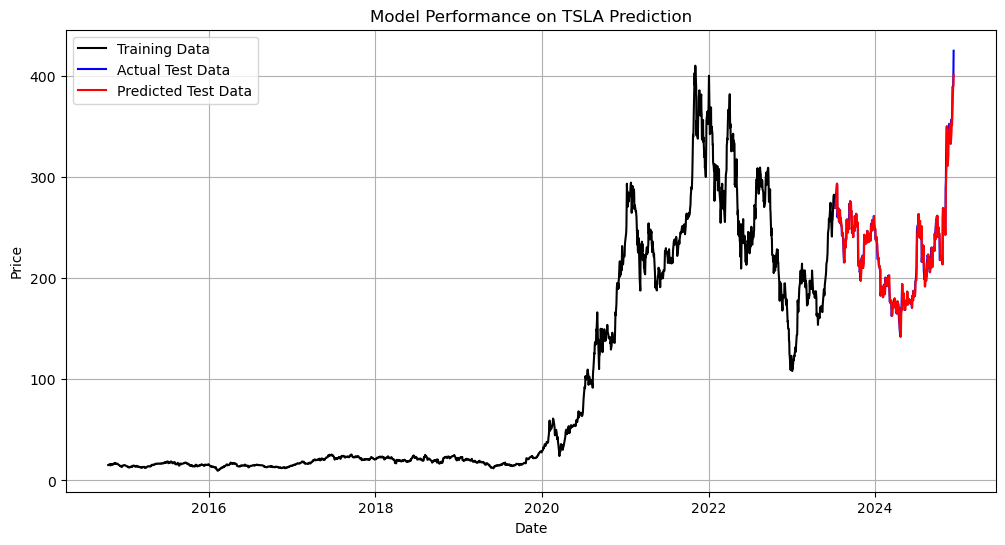


Starting prediction for stock: UNH
Training set shape for UNH: X_train: (2195, 1), y_train: (2195,)
Testing set shape for UNH: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for UNH: {'alpha': 0.01}
Performance for UNH - RMSE: 8.13


<Figure size 640x480 with 0 Axes>

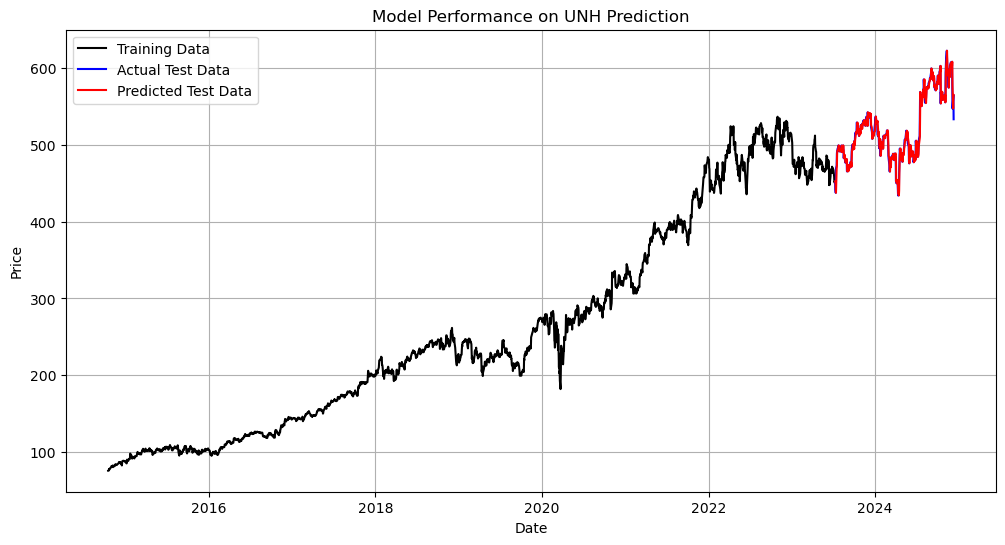


Starting prediction for stock: V
Training set shape for V: X_train: (2195, 1), y_train: (2195,)
Testing set shape for V: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for V: {'alpha': 0.01}
Performance for V - RMSE: 2.69


<Figure size 640x480 with 0 Axes>

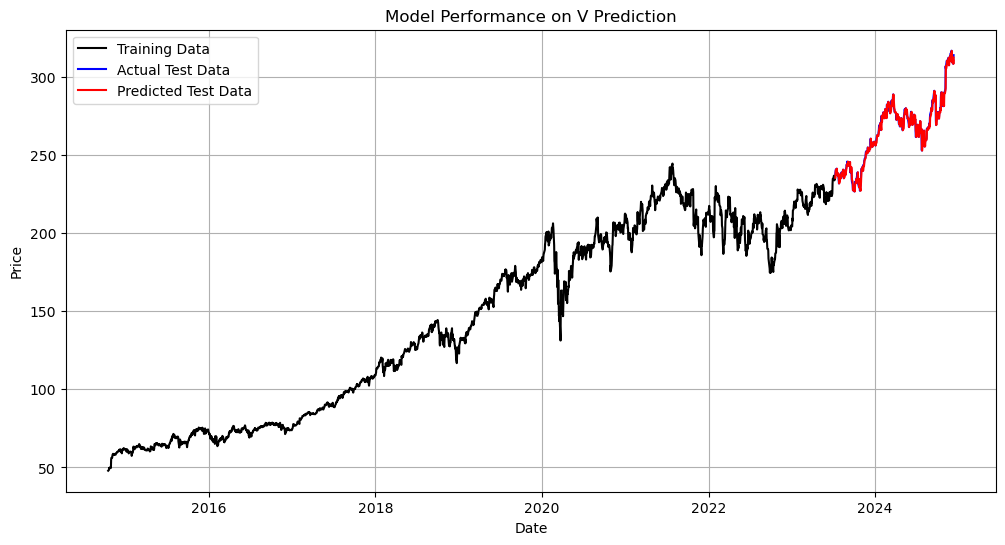


Starting prediction for stock: WMT
Training set shape for WMT: X_train: (2195, 1), y_train: (2195,)
Testing set shape for WMT: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for WMT: {'alpha': 0.01}
Performance for WMT - RMSE: 0.72


<Figure size 640x480 with 0 Axes>

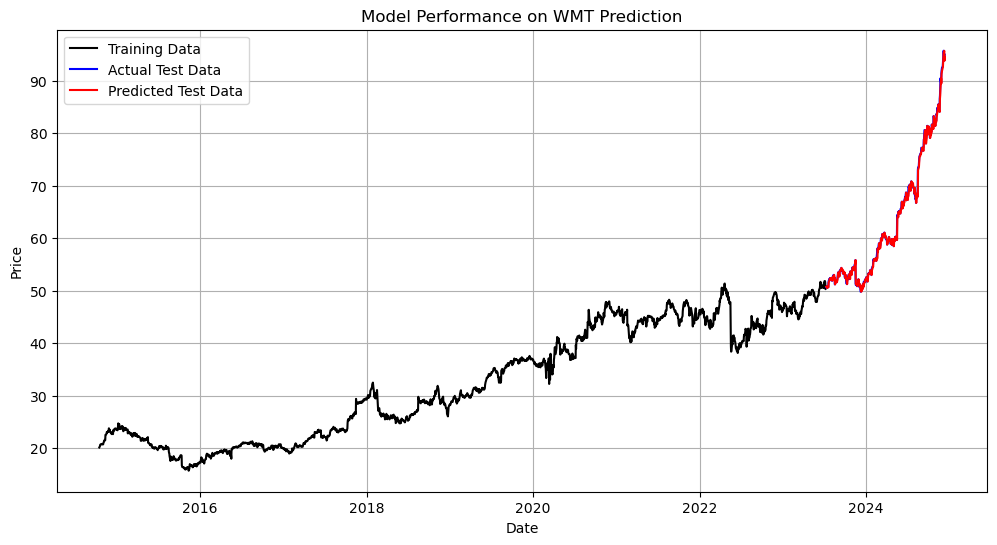


Starting prediction for stock: XOM
Training set shape for XOM: X_train: (2195, 1), y_train: (2195,)
Testing set shape for XOM: X_test: (360, 1), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for XOM: {'alpha': 0.01}
Performance for XOM - RMSE: 1.41


<Figure size 640x480 with 0 Axes>

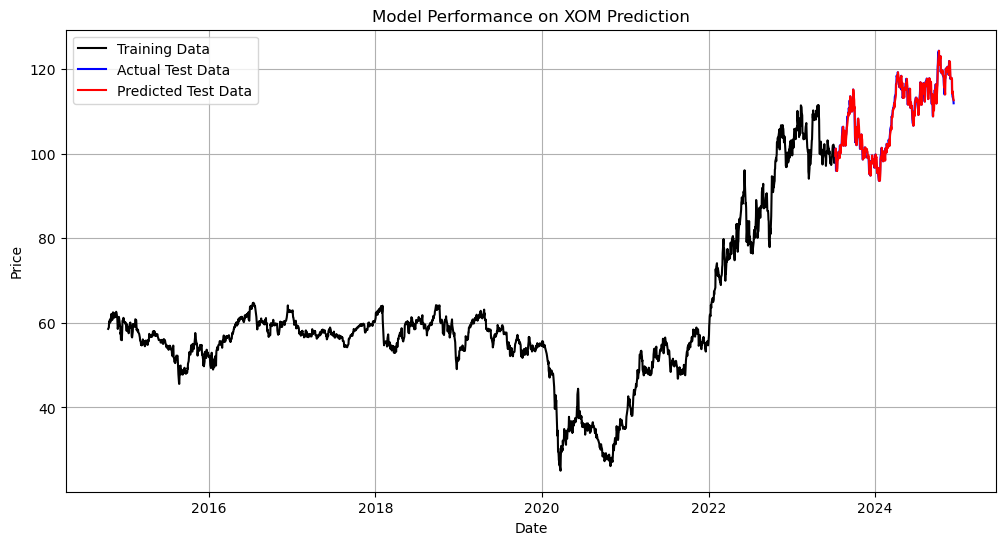


Summary of Results:
AAPL: RMSE = 2.68
AMZN: RMSE = 3.03
AVGO: RMSE = 3.74
COST: RMSE = 8.85
GOOG: RMSE = 2.69
GOOGL: RMSE = 2.69
HD: RMSE = 4.25
JPM: RMSE = 2.68
LLY: RMSE = 14.14
MA: RMSE = 4.47
META: RMSE = 9.58
MSFT: RMSE = 5.01
NVDA: RMSE = 2.95
ORCL: RMSE = 2.78
PG: RMSE = 1.49
TSLA: RMSE = 8.52
UNH: RMSE = 8.13
V: RMSE = 2.69
WMT: RMSE = 0.72
XOM: RMSE = 1.41


<Figure size 640x480 with 0 Axes>

In [46]:
# Initialize dictionaries to store results
results = {}

# Define the hyperparameter grid for GridSearchCV (alpha for regularization strength)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

# Fixed test size for the last 360 rows
test_size = 360

# Time Series Split for cross-validation (preserves order)
tscv = TimeSeriesSplit(n_splits=3)

# Define folder for saving plots
output_folder = "ridge_predictions"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Loop through each stock in the sp500 DataFrame
for stock in sp500.columns:

        print(f"\nStarting prediction for stock: {stock}")
        
        # Prepare the target (stock price) for each stock
        y_stock = sp500[stock]  # Stock price for this particular stock
        
        # Create univariate features: lagged price
        y_shifted = y_stock.shift(1).dropna()
        y_stock = y_stock.iloc[1:]

        # Define training and testing sets
        X_train = y_shifted[:-test_size].values.reshape(-1, 1)
        X_test = y_shifted[-test_size:].values.reshape(-1, 1)
        y_train = y_stock[:-test_size]
        y_test = y_stock[-test_size:]
        
        # Print dataset shapes
        print(f"Training set shape for {stock}: X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"Testing set shape for {stock}: X_test: {X_test.shape}, y_test: {y_test.shape}")
        
        # Initialize Ridge Regression model
        ridge_reg = Ridge()

        # Perform Grid Search with TimeSeriesSplit cross-validation
        grid_search = GridSearchCV(
            estimator=ridge_reg, 
            param_grid=param_grid, 
            cv=tscv, 
            scoring='neg_mean_squared_error', 
            verbose=1
        )
        
        # Fit the GridSearchCV model to the training data
        grid_search.fit(X_train, y_train)
        
        # Get the best hyperparameters from the grid search
        best_params = grid_search.best_params_
        print(f"Best Hyperparameters for {stock}: {best_params}")
        
        # Use the best estimator found by GridSearchCV to make predictions
        best_model = grid_search.best_estimator_
        
        # Make predictions on the test data
        y_pred = best_model.predict(X_test)
        
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        print(f"Performance for {stock} - RMSE: {rmse:.2f}")
        
        # Store the results (model, predictions, evaluation metrics)
        results[stock] = {
            'model': best_model, 
            'predictions': y_pred,
            'mse': mse,
            'rmse': rmse
        }
        
        # Combine training and testing actual prices for visualization
        plt.figure(figsize=(12, 6))
        
        # Plot training data (black)
        plt.plot(y_stock.index[:-test_size], y_stock.values[:-test_size], color='black', label='Training Data')
        
        # Plot actual test data (blue)
        plt.plot(y_stock.index[-test_size:], y_stock.values[-test_size:], color='blue', label='Actual Test Data')
        
        # Overlay the predicted prices for the test set (red)
        plt.plot(y_test.index, y_pred, color='red', label='Predicted Test Data')
        
        # Add title and labels
        plt.title(f'Model Performance on {stock} Prediction')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        
        # Display the plot
        plt.show()
        
        # Save the plot
        # Save the plot
        plt.savefig(f'../images/{stock}_ridge_prediction_uni.png', format='png')


# Final summary of results
print("\nSummary of Results:")
for stock, metrics in results.items():
    print(f"{stock}: RMSE = {metrics['rmse']:.2f}")